CRISPRi screening results analyzed with [ScreenProcessing](https://github.com/mhorlbeck/ScreenProcessing) pipeline. 

- Load screening result tables into python 
- Pathway enrichment analysis over the gamma and rho scores
- Make sure gene names are correctly assigned 
- Exploring correlations, differences, and intersections among the screens.

In [12]:
import sys
import pandas as pd
import numpy as np 
from itertools import chain, product

sys.path.append("../")
sys.path.append("/data_gilbert/home/aarab/Projects/ipage-down/")

from util import *
import ipage_down as ipd

In [13]:
# wd = '/rumi/shams/abe/Projects/Decitabine-treatment/'
wd = '/data_gilbert/home/aarab/Projects/Decitabine-treatment'

In [14]:
data = load_data(screens=True,wd=wd)

In [15]:
data['hl60'].keys()

dict_keys(['exp1_DAC_rho', 'exp1_DAC_gamma', 'exp2_DAC_rho', 'exp2_DAC_gamma', 'exp2_GSK_rho', 'exp2_GSK_gamma'])

## Phenotype-enrichment analysis
I've selected `ave_Rep1_Rep2` column together with gene names for both $\gamma$ (gamma) and $\rho$ (rho) scores as seprate two-column tables to run iPAGE for phenotype encrichment analysis. 

Run `iPAGE`:

In [16]:
from matplotlib import pyplot
# from scipy.stats import yeojohnson
# 'exp1_DAC_gamma'
# 'exp2_DAC_rho'
# 'exp2_DAC_gamma'
# 'exp2_GSK_rho'
# 'exp2_GSK_gamma'
# df = pd.concat(find_top(data['hl60']['exp1_DAC_rho'].astype(float),'rho score',0,'Mann-Whitney p-value',1)).reset_index()
df = data['hl60']['exp1_DAC_rho'].astype(float).reset_index()
df.to_csv('hl60_exp1_DAC_rho_delta_phenotype.txt',sep='\t',index=None, header=None)

In [17]:
# df.plot(x='rho score', y='Mann-Whitney p-value', kind='scatter')
# plt.show()
# # histogram
# pyplot.hist(df.iloc[:,0])
# pyplot.show()

https://github.com/goodarzilab/server_wiki/tree/main/lab_softwares

In [18]:
%reload_ext rpy2.ipython

In [19]:
%%R -i df -o data
data = df
data[['fdr']] <- sign(data[,'rho score'])*(1-data[,'Mann-Whitney p-value'])
data <- data[!is.na(data$'fdr'), ]
data <- data[, c('gene_name', 'fdr','rho score','Mann-Whitney p-value')]

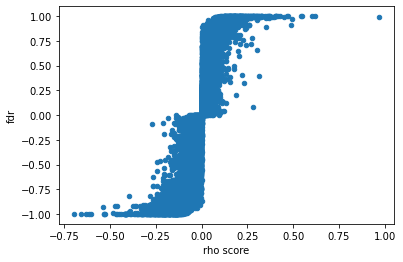

In [20]:
data.plot(x='rho score', y='fdr', kind='scatter')
data.to_csv('hl60_exp1_DAC_rho_delta_phenotype_fdr.txt',sep='\t',index=None, header=None)

plt.show()

https://medium.com/analytics-vidhya/techniques-to-transform-data-distribution-565a4d0f2da


In [21]:
# df.iloc[:,0] = yeojohnson(np.array(df.iloc[:,0]),lmbda=0.5)

# df.to_csv('hl60_exp1_DAC_rho_delta_phenotype.txt',sep='\t')

# df.plot(x='rho score', y='Mann-Whitney p-value', kind='scatter')
# plt.show()

# # histogram
# pyplot.hist(df.iloc[:,0])
# pyplot.show()

# Pathway enrichment analysis

In [33]:
# rm -rv hl60_exp1_DAC_rho_delta_phenotype

In [ ]:
%%bash 
export PAGEDIR=/data_gilbert/home/aarab/iPAGE

nohup ls *delta_phenotype*.txt | parallel -j18 -k bash ipage_loop.sh  {} &> ipage.out

___

In [22]:
idx=pd.IndexSlice

In [23]:
# PAGE_rho = ipd.make_ipage_run_data_frame('hl60_exp1_DAC_rho_delta_phenotype/')
PAGE = ipd.make_ipage_run_data_frame('hl60_exp1_DAC_rho_delta_phenotype_fdr/')

In [24]:
# PAGE = pd.concat([
#     PAGE_rho.loc[
#         set(PAGE_rho.index.to_list()).intersection(set(PAGE_fdr.index.to_list()) ),
#     ],
#     PAGE_fdr.loc[
#         set(PAGE_rho.index.to_list()).intersection(set(PAGE_fdr.index.to_list()) ),
#     ]],axis=1)


PAGE.style.background_gradient(cmap='coolwarm',axis=None,vmin=-2,vmax=2)

,,[-1.00 -0.89],[0.88 1.00]
gene_set,gs_cluster,,
REACTOME_MITOCHONDRIAL_TRANSLATION,human_c2_gs,-2.099000,10.339000
REACTOME_HATS_ACETYLATE_HISTONES,human_c2_gs,2.874000,6.248000
REACTOME_S_PHASE,human_c2_gs,6.989000,1.578000
REACTOME_RNA_POLYMERASE_III_TRANSCRIPTION,human_c2_gs,-0.958000,6.007000
PID_IL8_CXCR2_PATHWAY,human_c2_gs,1.578000,2.097000
REACTOME_TP53_REGULATES_TRANSCRIPTION_OF_ADDITIONAL_CELL_CYCLE_GENES_WHOSE_EXACT_ROLE_IN_THE_P53_PATHWAY_REMAIN_UNCERTAIN,human_c2_gs,4.560000,-0.827000
YU_MYC_TARGETS_UP,human_c2_gs,2.390000,2.396000
REACTOME_NEGATIVE_FEEDBACK_REGULATION_OF_MAPK_PATHWAY,human_c2_gs,-0.248000,6.257000
RAMPON_ENRICHED_LEARNING_ENVIRONMENT_EARLY_UP,human_c2_gs,4.009000,-0.579000


In [25]:
ann = ipd.make_annotation_dict(PAGE.loc[idx[:,['human_c5_gs','human_h_gs']],],gz=False)
ann.update(ipd.make_annotation_dict(PAGE.loc[idx[:,['human_go_gs']],]))

In [26]:
ann['GO_TRNA_WOBBLE_URIDINE_MODIFICATION']

{'names': ['GO_TRNA_WOBBLE_URIDINE_MODIFICATION', 'P', 'human_c5_gs'],
 'genes': ['DPH3P1',
  'DPH3',
  'ELP4',
  'ELP2',
  'KTI12',
  'ELP5',
  'MTO1',
  'MOCS3',
  'CTU2',
  'ELP6',
  'ELP3',
  'TRMU',
  'TRMT9B',
  'URM1',
  'GTPBP3',
  'ELP1',
  'CTU1',
  'ALKBH8']}

In [34]:
cat hl60_exp1_DAC_rho_delta_phenotype/human_c5_gs/output.ipage_intersections | grep GO_TRNA_WOBBLE_URIDINE_MODIFICATION | grep 10

GO_TRNA_WOBBLE_URIDINE_MODIFICATION GO_TRNA_WOBBLE_URIDINE_MODIFICATION	10	ALKBH8	CTU1	CTU2	ELP2	ELP3	ELP4	ELP5	ELP6	GTPBP3	KTI12


## EnrichR

In [17]:
# # GO = pd.read_csv('~/iPAGE/PAGE_DATA/ANNOTATIONS/human_go_gs/human_go_gs_names.txt',sep='\t',header=None)
# gmt = pd.read_csv('~/Projects/ipage-down/annotations/human_go_gs/human_go_gs.gmt.gz',sep='\t',header=None)

# # GO.columns = ['ID','Term','Cluster']
# # GO = GO.set_index('ID')

In [35]:
# GO.loc[['N6-adenosine' in term for term in GO.Term],:]


In [36]:
import gseapy as gp
help(gp.enrichr)

Help on function enrichr in module gseapy.enrichr:

enrichr(gene_list, gene_sets, description='', outdir='Enrichr', cutoff=0.05, format='pdf', figsize=(8, 6), top_term=10, no_plot=False, verbose=False)
    Enrichr API.
    
    :param gene_list: Flat file with list of genes, one gene id per row, or a python list object
    :param gene_sets: Enrichr Library to query. Required enrichr library name(s). Separate each name by comma.
    :param description: name of analysis. optional.
    :param outdir: Output file directory
    :param float cutoff: Adjust P-value cutoff, for plotting. Default: 0.05
    :param str format: Output figure format supported by matplotlib,('pdf','png','eps'...). Default: 'pdf'.
    :param list figsize: Matplotlib figsize, accept a tuple or list, e.g. (width,height). Default: (6.5,6).
    :param bool no_plot: if equal to True, no figure will be draw. Default: False.
    :param bool verbose: Increase output verbosity, print out progress of your job, Default: False.


Alex Ge: 
> If we do Enrichr analysis on the resistance/sensitivity hits defined by Max’s cutoffs, (n = 418 genes), we do see mRNA methylation (adj p = 0.018) and RNA destabilization (adj p = 0.005) come out as significant GO biological processes. METTL3 is included in these GO terms.

> If we do Enrichr analysis on just the resistance hits (n = 197), mRNA methylation is even more significant (adj p = 0.002), which makes sense since we see more METTL3 biology on the resistance side. It is one of the top five GO terms by adjusted P-value.

> This analysis was done today with the 2021 GO terms, which have updated annotations for the newer m6A genes. When I did the same Enrichr analysis in 2018, RNA destabilization and mRNA methylation were not as significant since the GO annotations were not updated.

> I think Enrichr analysis might make more sense here – in Abe’s analysis, I can see that a lot of rho scores that are < 0.2 are being included in the analysis; these are likely to be statistically insignificant. It also looks graphically like the highest bin is including rho values that are < 0?


In [37]:
import os
os.environ['http_proxy'] = "http://marlowe-proxy:3128"
os.environ['https_proxy'] = "https://marlowe-proxy:3128"

In [38]:
resistance = open("resistance.txt", "w")
for gene in df.gene_name[df.iloc[:,1] > 0.2].to_list():
    resistance.write(gene + "\n")
resistance.close()

sensitivity = open("sensitivity.txt", "w")
for gene in df.gene_name[df.iloc[:,1] < -0.2].to_list():
    sensitivity.write(gene + "\n")
sensitivity.close()

In [39]:
# # run enrichr
# # enrichr(gene_list, gene_sets, description='', outdir='Enrichr', cutoff=0.05, format='pdf', figsize=(8, 6), top_term=10, no_plot=False, verbose=False)
# enr = gp.enrichr(gene_list=df.gene_name[df.iloc[:,1] > 0.2].to_list(),
#                  description='resistance',
#                  gene_sets="GO_Biological_Process",
#                  outdir='enrichr_go',
#                  cutoff=0.5, # only used for testing.
#                  verbose=True
#                 )

In [40]:
# enr = gp.enrichr(gene_list=df.gene_name[df.iloc[:,1] < -0.2].to_list(),
#                  description='sensitivity',
#                  gene_sets="GO_Biological_Process_2021",
#                  outdir='enrichr_go',
#                  cutoff=0.5, # only used for testing.
#                  verbose=True
#                 )

I've used the resistance genes manually to use [EnrichR](https://maayanlab.cloud/Enrichr/) webtool. 

In [41]:
enrichr = pd.read_csv('resistance-GO_Biological_Process_2021_table.txt', sep = '\t')

In [42]:
tRNA_terms = enrichr[
    [('tRNA' in term) for term, genes in zip(enrichr.Term, enrichr.Genes)]
].sort_values('Combined Score',ascending=False)#.head(n=10)

METTL3_terms = enrichr[
    [('METTL3' in genes) for term, genes in zip(enrichr.Term, enrichr.Genes)]
].sort_values('Combined Score',ascending=False)#.head(n=10)

In [43]:
my_terms = pd.concat([METTL3_terms.iloc[0:3,:], tRNA_terms.iloc[0:1,:]],axis=0)

In [44]:
my_terms

,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
6,mRNA methylation (GO:0080009),4/15,5.411388e-06,0.000790,0,0,45.342481,549.868493,TRMT10C;METTL3;ZC3H13;CBLL1
27,delamination (GO:0060232),2/7,1.349594e-03,0.046513,0,0,49.272050,325.587310,YTHDF2;METTL3
9,mRNA modification (GO:0016556),4/22,2.773701e-05,0.002835,0,0,27.699511,290.643851,TRMT10C;METTL3;ZC3H13;CBLL1
0,tRNA wobble base modification (GO:0002097),5/14,6.378393e-08,0.000033,0,0,69.718706,1155.083106,CTU1;KTI12;ELP3;ELP4;ALKBH8


In [177]:
%%R
library(ggplot2)
library(tidyverse)
library(RColorBrewer)
library(patchwork)

In [91]:
%%R -i enrichr
# https://stackoverflow.com/questions/10688137/how-to-fix-spaces-in-column-names-of-a-data-frame-remove-spaces-inject-dots


In [298]:
%%R 
plot_enrichr <- function(enrichr,n=7){
    
    enrichr <- enrichr %>% dplyr::rename_all(funs(make.names(.)))

    enrichr$Term <- as.character(enrichr$Term)
    enrichr$Combined.Score <- as.numeric(enrichr$Combined.Score) 
    enrichr$Adjusted.P.value <- as.numeric(enrichr$Adjusted.P.value) 

    enrichr$Term <- gsub(' [(]GO.*', '', enrichr$Term)

    enrichr$star <- ifelse(
        enrichr[['Adjusted.P.value']] < 0.001, ' ***', 
        ifelse(
            enrichr[['Adjusted.P.value']] >= 0.001 & enrichr[['Adjusted.P.value']] < 0.01, ' **',
            ifelse(enrichr[['Adjusted.P.value']] >= 0.01 & enrichr[['Adjusted.P.value']] < 0.05, ' *', ' ')
        )
    )

    p <- arrange(enrichr,desc(Combined.Score))[1:n,] %>% 
    ggplot(aes(x = reorder(Term,Combined.Score), y = log(Combined.Score), label = star)) +
        geom_bar(stat = 'identity', width = 0.65, fill = brewer.pal(8, 'Accent')[3], color = brewer.pal(2, 'Accent')[3]) +
        theme_classic() +
        coord_flip() +
        geom_text(hjust = -0.02, vjust = 0.5, size = 2) +
        theme(axis.text.x = element_text(size = 6, color = 'black'),
              axis.text.y = element_text(size = 9, color = 'black'), 
              axis.title.x = element_text(size = 9),
              axis.title.y = element_blank()
              ) +
        ylab('\nErichment score') #+
        # scale_y_continuous(expand = c(0,0), limits = c(0,47))
    
    return (p)

}

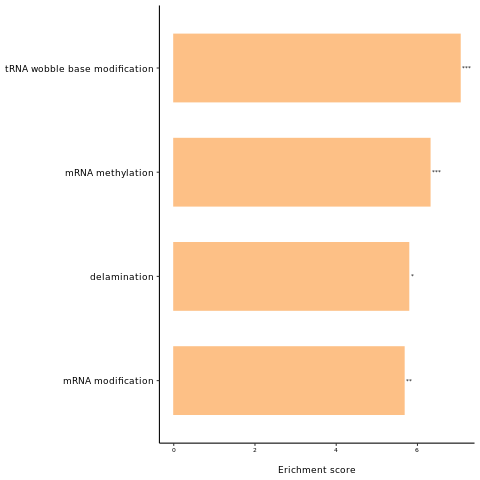

In [299]:
%%R -i my_terms
p = plot_enrichr(my_terms,n=4)
ggsave('resistance.pdf',p, height = 3, width = 3)
p

# Pairwise correlations

Using `.iloc` induced the pandas into an object instead of dataframe, so `corr()` didn't work. Here is the solution: https://stackoverflow.com/questions/55251166/pandas-corr-returning

Then, using https://stackoverflow.com/questions/29432629/plot-correlation-matrix-using-pandas

In [112]:
# import seaborn as sns
# import matplotlib.pyplot as plt
# from matplotlib.pyplot import subplots
# from venn import venn 

In [111]:
# def drug_score_df(data, DRUG, SCORE):
#     '''
#     A function to read screening data for given score and drug
#     '''
#     all_genes = [set(data[cell][key].index) for cell in data for key in data[cell] if DRUG in key and SCORE in key]
#     genes = all_genes[0].intersection(*all_genes[1:])
    
#     keys = ['_'.join([cell,key]) for cell in data for key in data[cell] if DRUG in key and SCORE in key]
#     cols = [col[0]+col[1] for col in product(keys,[' score',' pvalue'])]
    
#     all_df = [data[cell][key].loc[genes] for cell in data for key in data[cell] if DRUG in key and SCORE in key]
    
#     df = pd.concat(all_df, axis=1).dropna().astype(float)
#     df.columns = cols
    
#     return df

### DAC $\gamma$-score

In [110]:
# df = drug_score_df(data,'DAC','gamma').filter(like='score',axis=1)
# plot_corr(df)
# df.corr().style.background_gradient(cmap='coolwarm',axis=None,vmin=0.5)

### DAC $\rho$-score

In [109]:
# df = drug_score_df(data,'DAC','rho').filter(like='score',axis=1)
# plot_corr(df)
# df.corr().style.background_gradient(cmap='coolwarm',axis=None)

# Intersection

In [108]:
# def intersection_analysis(SCORE,score_thr = 0.1,pvalue_thr = 1):

#     raw_df = drug_score_df(data,'DAC',SCORE)
#     exps = set([col.split(f'_{SCORE}')[0] for col in raw_df.columns.tolist()])

#     dfs = [[e,raw_df.filter(like=e,axis=1)] for e in exps]

#     results = []
#     for exp in dfs:
#         print(exp[0])
#         results.append([exp[0]] + [find_top(
#             exp[1],
#             f'{exp[0]}_{SCORE} score', score_thr,
#             f'{exp[0]}_{SCORE} pvalue', pvalue_thr
#         )])

#     studies = dict()
#     for res in results:
#         up,dn = res[1]
#         studies[res[0]] = {}
#         studies[res[0]]['up'] = set(up.index)
#         studies[res[0]]['dn'] = set(dn.index)

#     _, axs = subplots(ncols=2, nrows=1, figsize=(15, 5))

#     venn(dict([[std,studies[std]['up']] for std in studies]),fontsize=10,legend_loc="upper left",ax=axs[0])
#     axs[0].set_title(f"Up\n{SCORE} score >= {score_thr} &\n P-Value < {pvalue_thr}",fontsize=16)

#     venn(dict([[std,studies[std]['dn']] for std in studies]),fontsize=10,legend_loc="upper left",ax=axs[1])
#     axs[1].set_title(f"Down\n{SCORE} score <= {-1*score_thr} &\n P-Value < {pvalue_thr}",fontsize=16)

#     plt.show()

In [10]:
# def find_hits(df, pvalue_thr = 0.05, score_thr = 0.1):
#     up = df.index[
#         (df.iloc[:,0] >= score_thr) &
#         (df.iloc[:,1] < pvalue_thr)
#     ]
#     dn = df.index[
#         (df.iloc[:,0] <= -1*score_thr) &
#         (df.iloc[:,1] < pvalue_thr)
#     ]
    
#     return up, dn

### DAC $\rho$-score

In [107]:
# intersection_analysis('rho')

### DAC $\gamma$-score

In [106]:
# intersection_analysis('gamma')

## m6A reader and writer genes 
[Table 1](https://www.nature.com/articles/s41419-017-0129-x/tables/1) at
> Dai, D., Wang, H., Zhu, L. et al. N6-methyladenosine links RNA metabolism to cancer progression. _Cell Death Dis_ **9**, 124 (2018). https://doi.org/10.1038/s41419-017-0129-x

In [105]:
# table = pd.read_csv('../m6A-genes.tsv', sep = '\t')

# # Clean and filter above table to take matched gene names for further analysis:
# m6A_genes = table.Names.tolist()
# RBMs = m6A_genes[4].split(' and its paralogue ')
# m6A_genes.remove(m6A_genes[4])
# m6A_genes = m6A_genes+RBMs

# table 

Add heatmap!

In [104]:
# def plot_score_heatmap(score, drug, genes):
#     df = drug_score_df(data,drug,score)
#     # keep non-missing gene names 
#     genes = [gene for gene in genes if gene in df.index.tolist()]

#     # draw heatmap
#     sns.set_theme()

#     sc_df = df.loc[genes].filter(like='score')
#     sc_df.columns = [c.replace(f'_{score} score','') for c in sc_df.columns]
    
#     pv_df= df.loc[genes].filter(like='pvalue')
#     pv_df.columns = [c.replace(f'_{score} pvalue','') for c in pv_df.columns]

#     _, (ax1,ax2) = subplots(ncols=2, nrows=1, figsize=(15, 5))

#     pv = sns.heatmap(pv_df, vmin=0, vmax=0.05, annot=True, linewidth=0.1,ax=ax1, cbar=False,cmap="YlGnBu")
#     pv.set_ylabel('')
#     pv.set_xlabel('')
#     ax1.set_title('P-Values', fontsize=15)

#     sc = sns.heatmap(sc_df, vmin=-0.2, vmax=0.2, annot=True, linewidth=0.1,ax=ax2,yticklabels=False)
#     sc.set_ylabel('')
#     sc.set_xlabel('')
#     ax2.set_title(f'{score} scores', fontsize=15)

#     # rotate the ticklabels correctly:
#     for ax in [sc,pv]:
#         tl = ax.get_xticklabels()
#         ax.set_xticklabels(tl, rotation=45)
#     plt.show()

### Rho score of DAC m6A genes 

In [103]:
# plot_score_heatmap('rho', 'DAC', m6A_genes)

### Rho score of GSK m6A genes 

In [102]:
# plot_score_heatmap('rho', 'GSK', m6A_genes)

In [ ]:
# %reload_ext rpy2.ipython

In [ ]:
# %%R 
# library (ggplot2)

# plot_Save <- function (p, name_it){
#     ggsave(paste(name_it,'png',sep='.'), plot = p, device = 'png', dpi = 300)
#     ggsave(paste(name_it,'pdf',sep='.'), plot = p, device = 'pdf', dpi = 300)
# }


# plot_Hist = function(res, title, x_min=-0.5,x_max=0.5){
# #     w <- wilcox.test(res$logFC, mu=0, alternative = "greater")
# #     t <- t.test(res$logFC, mu=0, alternative = "greater")
#     h = ggplot(res, aes(x=logFC)) + 
#         ggtitle(title) +#,sprintf(
# #             "wilcox.test (-log10 p.value): %.5f \nt.test (-log10 p.value):%.5f \n[mu=0,alter=greater]", 
# #             -log10(w$p.value), -log10(t$p.value))) +
#         xlim(c(x_min,x_max)) +
#         geom_histogram(binwidth=0.001)

#     return (h)
# } 


In [ ]:
# %%R -i res
# plot_Hist(res, 'Rho score')